In [1]:
#Based on: https://chroniclesofai.com/transfer-learning-with-keras-resnet-50/
#and https://github.com/nachi-hebbar/Transfer-Learning-ResNet-Keras/blob/main/ResNet_50.ipynb
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import pathlib
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense,Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam


2023-11-14 14:16:08.275636: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-14 14:16:08.316787: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-14 14:16:08.316817: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-14 14:16:08.316846: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-14 14:16:08.323988: I tensorflow/core/platform/cpu_feature_g

In [2]:
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)
img_height,img_width=180,180
batch_size=128

In [3]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 3670 files belonging to 5 classes.
Using 2936 files for training.


2023-11-14 14:16:11.758475: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38375 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:17:00.0, compute capability: 8.0
2023-11-14 14:16:11.760499: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 38375 MB memory:  -> device: 1, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:98:00.0, compute capability: 8.0


Found 3670 files belonging to 5 classes.
Using 734 files for validation.


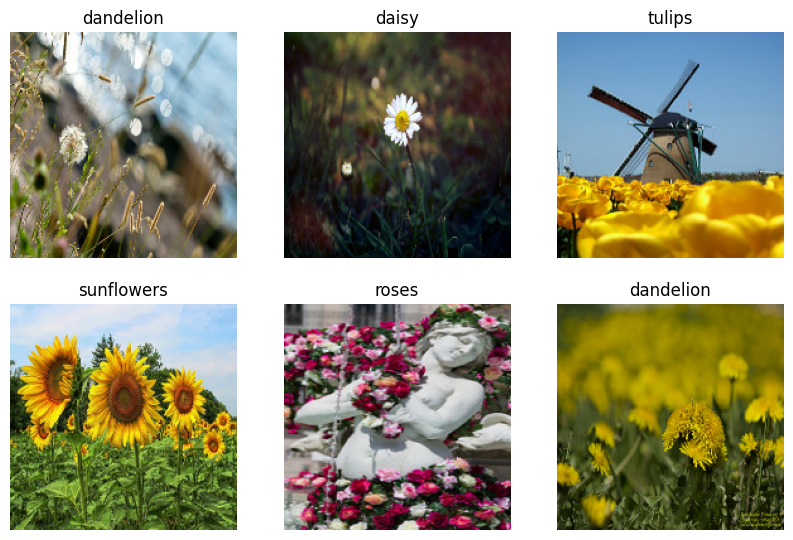

In [4]:
import matplotlib.pyplot as plt
class_names = train_ds.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(6):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [5]:
resnet_model = Sequential()

pretrained_model= tf.keras.applications.ResNet50(include_top=False,
                   input_shape=(180,180,3),
                   pooling='avg',classes=5,
                   weights='imagenet')
for layer in pretrained_model.layers:
        layer.trainable=False

resnet_model.add(pretrained_model)
resnet_model.add(Flatten())
resnet_model.add(Dense(512, activation='relu'))
resnet_model.add(Dense(5, activation='softmax'))
resnet_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dense_1 (Dense)             (None, 5)                 2565      
                                                                 
Total params: 24639365 (93.99 MB)
Trainable params: 1051653 (4.01 MB)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________


In [6]:
resnet_model.compile(optimizer=Adam(learning_rate=0.001),loss='sparse_categorical_crossentropy',metrics=['accuracy'])
history = resnet_model.fit(train_ds, validation_data=val_ds, epochs=10)

Epoch 1/10


2023-11-14 14:16:19.086388: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-11-14 14:16:20.272267: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x14d524045c30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-14 14:16:20.272300: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A100-PCIE-40GB, Compute Capability 8.0
2023-11-14 14:16:20.272306: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (1): NVIDIA A100-PCIE-40GB, Compute Capability 8.0
2023-11-14 14:16:20.277531: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-11-14 14:16:20.392478: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


23/23 [==============================] - 8s 165ms/step - loss: 1.2352 - accuracy: 0.6441 - val_loss: 0.5618 - val_accuracy: 0.7997
Epoch 2/10
23/23 [==============================] - 2s 66ms/step - loss: 0.3554 - accuracy: 0.8750 - val_loss: 0.3682 - val_accuracy: 0.8556
Epoch 3/10
23/23 [==============================] - 2s 66ms/step - loss: 0.2368 - accuracy: 0.9254 - val_loss: 0.3338 - val_accuracy: 0.8665
Epoch 4/10
23/23 [==============================] - 2s 66ms/step - loss: 0.1691 - accuracy: 0.9482 - val_loss: 0.3308 - val_accuracy: 0.8801
Epoch 5/10
23/23 [==============================] - 2s 66ms/step - loss: 0.1157 - accuracy: 0.9745 - val_loss: 0.3208 - val_accuracy: 0.8801
Epoch 6/10
23/23 [==============================] - 2s 66ms/step - loss: 0.0847 - accuracy: 0.9847 - val_loss: 0.3321 - val_accuracy: 0.8842
Epoch 7/10
23/23 [==============================] - 2s 67ms/step - loss: 0.0609 - accuracy: 0.9908 - val_loss: 0.3477 - val_accuracy: 0.8719
Epoch 8/10
23/23 [=====

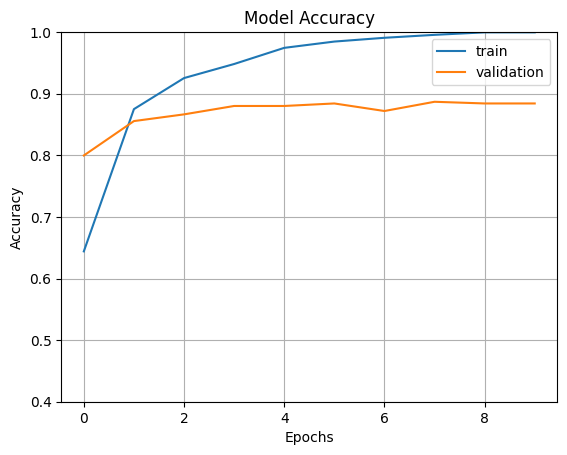

In [7]:
fig1 = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()